In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# Vérification de la corruption des images
import os

num_skipped = 0
for folder_name in ("Birds","Cat","Chameleon","Chicken", "Dog", "Frog", "Gecko", "Hamster", "Iguana","Lizard","Random","Rat","Salamander","Snake","Toad","Turtle_Tortoise"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [18]:
image_size = (180, 180)
batch_size = 32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 38233 files belonging to 16 classes.
Using 7646 files for validation.
Found 38233 files belonging to 16 classes.
Using 30587 files for training.


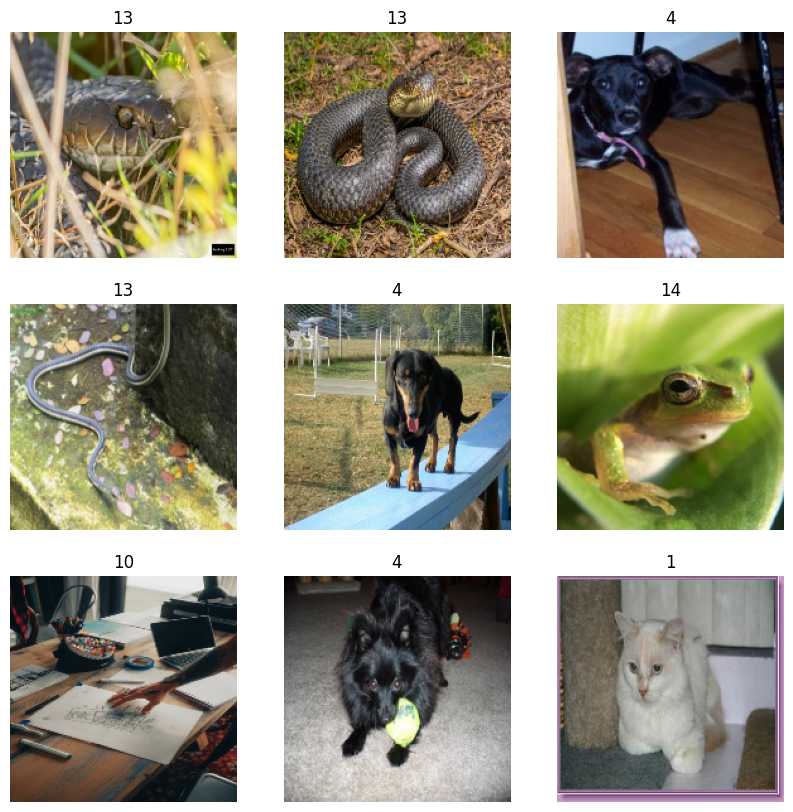

In [19]:
# Affichage d'un exemple de dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [20]:
# Augmentation des données

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

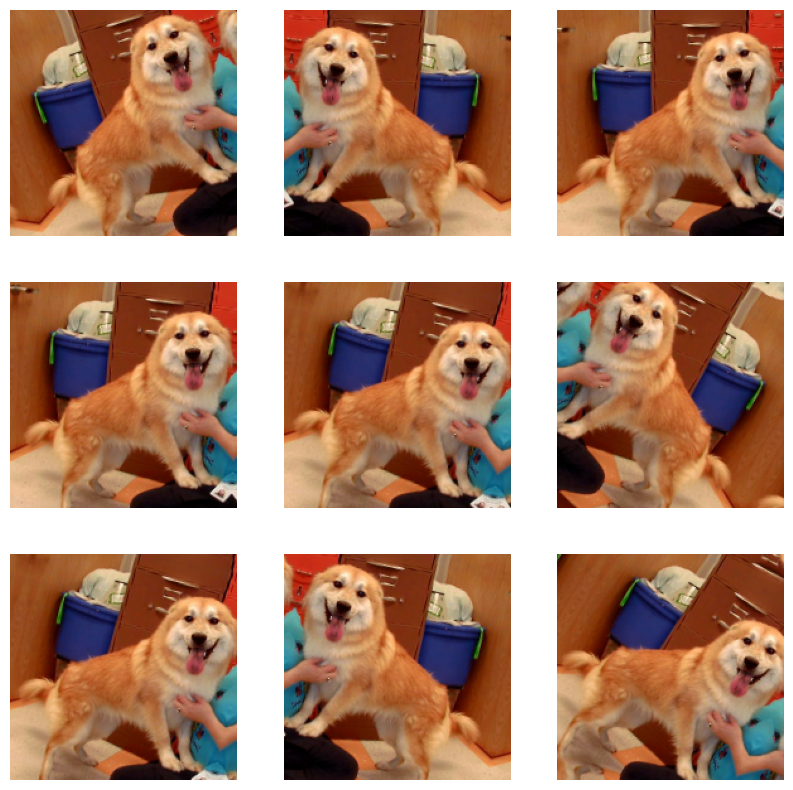

In [21]:
# Affichage d'un exemple d'augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [22]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Optimisation de la vitesse de chargement des données pour les GPU

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

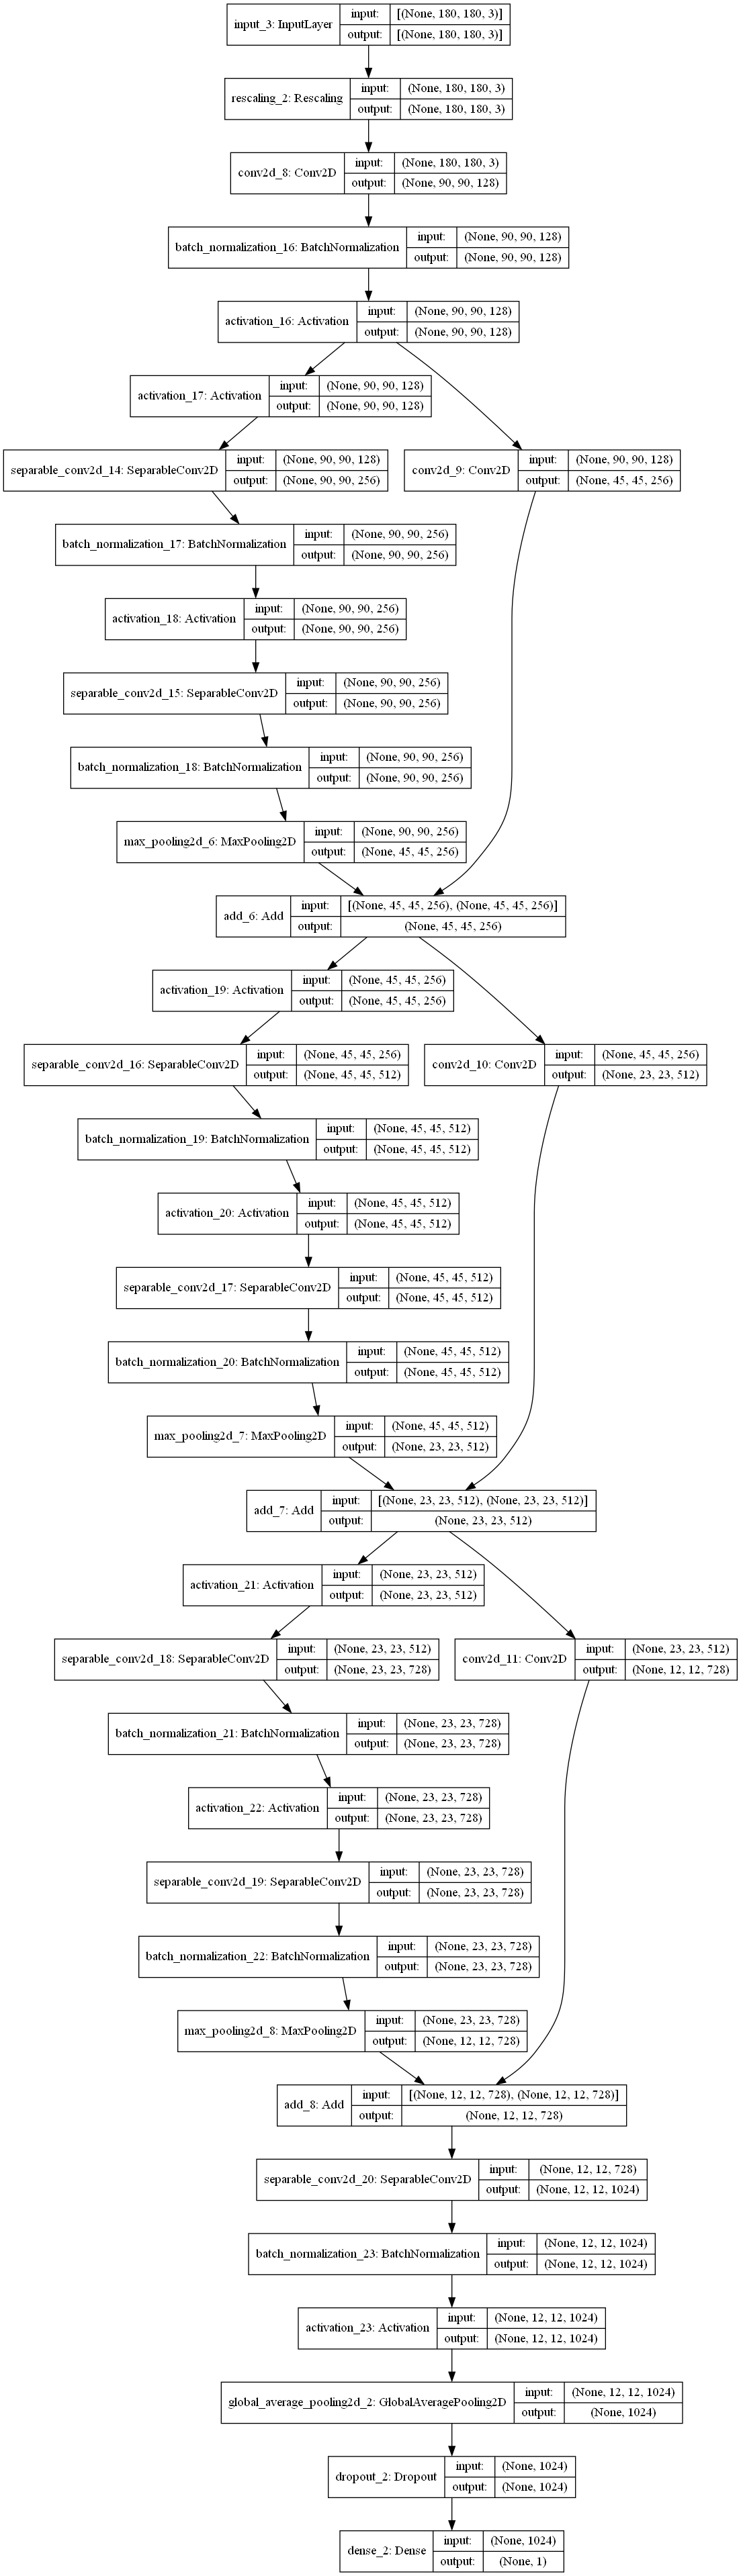

In [29]:
# Création du modèle

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 16:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=16)
keras.utils.plot_model(model, show_shapes=True)

In [9]:
# Récupération du model
from tensorflow.keras.models import load_model

model = load_model("./model", compile=False)

In [30]:
# Entrainement du modèle

epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

956/956 [==============================] - 433s 451ms/step - loss: -4477.5039 - accuracy: 0.3023 - val_loss: -19268.8965 - val_accuracy: 0.3126


C:\Users\natha\PycharmProjects\pythonProject1\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
# Sauvegarde du modèle
model.save("./model")

INFO:tensorflow:Assets written to: ./model\assets


C:\Users\natha\PycharmProjects\pythonProject1\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [34]:
# Test du modèle sur une image

img = keras.preprocessing.image.load_img(
    "ztest/cat.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
print(img_array)
predictions = model.predict(img_array)
print(predictions)
score = float(predictions[0])
print(score)
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

tf.Tensor(
[[[[ 87. 101. 101.]
   [102. 116. 116.]
   [ 98. 107. 112.]
   ...
   [222. 227. 230.]
   [219. 224. 227.]
   [220. 225. 228.]]

  [[ 98. 116. 120.]
   [ 96. 120. 122.]
   [108. 126. 128.]
   ...
   [222. 227. 230.]
   [220. 225. 228.]
   [218. 223. 226.]]

  [[112. 135. 141.]
   [114. 138. 142.]
   [102. 122. 123.]
   ...
   [220. 225. 228.]
   [218. 223. 226.]
   [218. 223. 226.]]

  ...

  [[154. 130. 106.]
   [158. 134. 110.]
   [161. 137. 113.]
   ...
   [176. 152. 128.]
   [177. 153. 129.]
   [179. 155. 131.]]

  [[159. 135. 111.]
   [158. 134. 110.]
   [158. 134. 110.]
   ...
   [176. 152. 128.]
   [176. 152. 126.]
   [176. 152. 126.]]

  [[161. 136. 116.]
   [160. 135. 113.]
   [159. 135. 111.]
   ...
   [173. 153. 128.]
   [176. 152. 128.]
   [176. 152. 128.]]]], shape=(1, 180, 180, 3), dtype=float32)
[[1.]]
1.0
This image is 0.00% cat and 100.00% dog.
